# EX_10 인물사진을 만들어 보자

## __1. Import__

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings(action='ignore')

import urllib # 웹에서 데이터를 다운로드할 때 사용
import cv2 # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

## __2. Data__

### __2.1 이미지 불러오기__

(1440, 1079, 3)


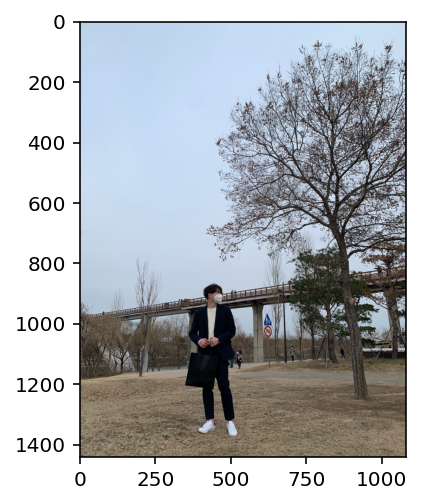

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hangang.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## __3. Model__

### __3.1 모델 설정__

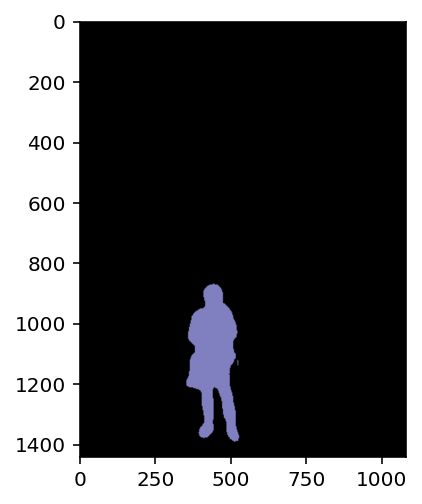

In [3]:
# 저장할 파일 이름
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

### __3.2 컬러맵 만들기__

In [4]:
# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# color_map 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# label 이름과 크로마키하는 색깔 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id], colormap[class_id])

background [0 0 0]
person [192 128 128]


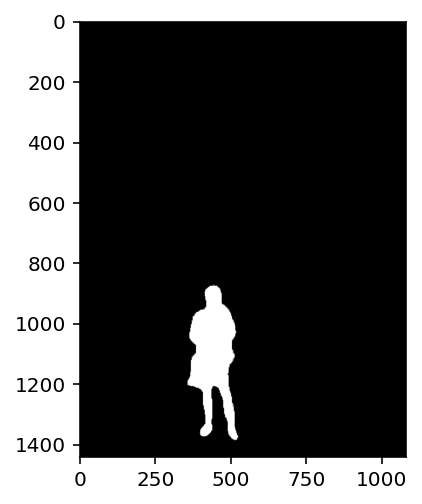

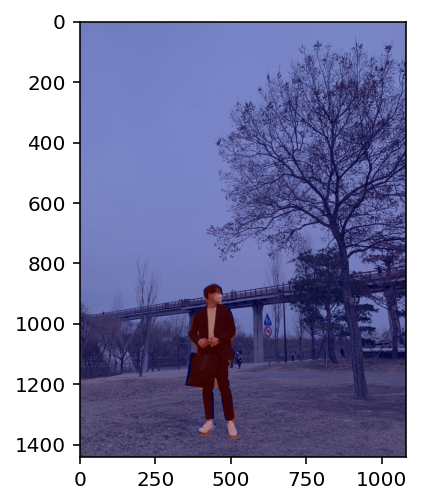

In [5]:
# 사람 object 구별하는 색깔 (BGR)
seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)

# 흑백사진으로 바꾸기
plt.imshow(seg_map, cmap='gray')
plt.show()


# 색깔 넣어서 잘 나눠졌나 확인해보기
img_show = img_orig.copy()
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### __3.3 모델 적용해서 블러 처리 하기__

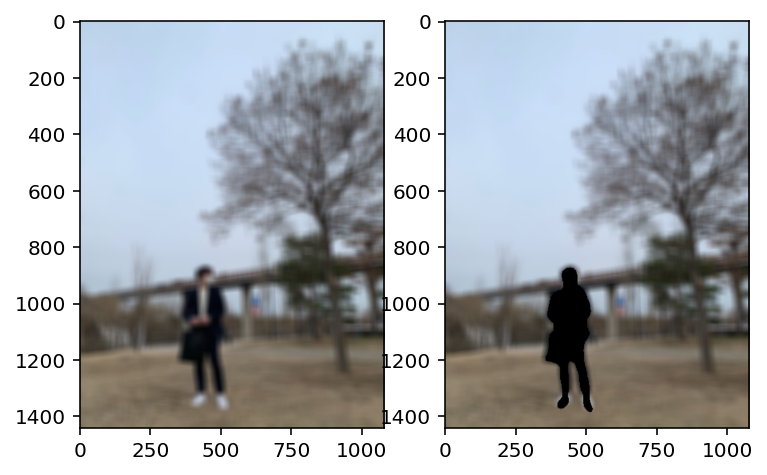

In [6]:
img_orig_blur = cv2.blur(img_orig, (30,30))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### __3.4 완성 품__

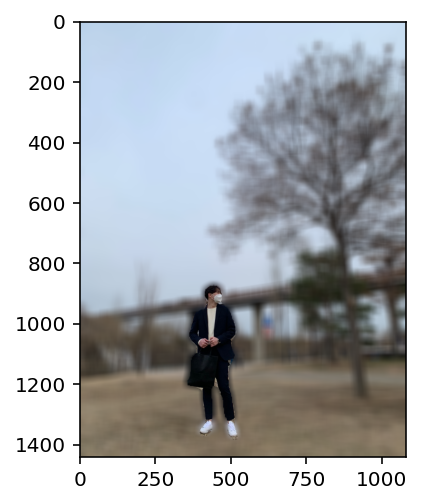

In [7]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## __4. 다른 배경에 넣어 보기__

In [8]:
def focusing(file, obj, back = None):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + file  
    img_orig = cv2.imread(img_path) 
    
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)
    
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    seg_color = tuple(colormap[LABEL_NAMES.index(obj)][::-1])
        
    seg_map = np.all(output==seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
        
    plt.subplot(121)
    plt.title('적용 전')
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    
    img_orig_blur = cv2.blur(img_orig, (30,30))
    plt.subplot(122)
    plt.title('적용 후')
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.subplot(121)
    plt.title('인식')
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.subplot(122)
    plt.title('완성')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    if back:
        img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + back
        img_back = cv2.imread(img_path) 
        img_resized = cv2.resize(img_orig, (img_back.shape[1], img_back.shape[0]))
        img_mask_resized = cv2.resize(img_mask_color, (img_back.shape[1], img_back.shape[0]))
        img_background_concat = np.where(img_mask_resized == 255, img_resized, img_back)
        plt.subplot(121)
        plt.title('')
        plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
        plt.show()

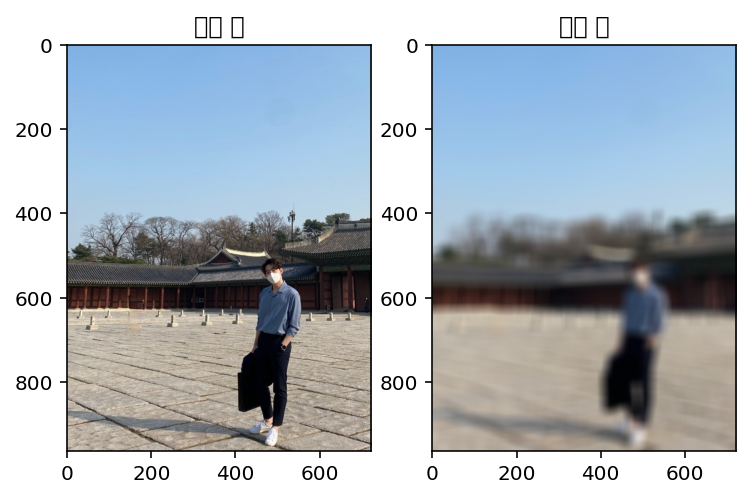

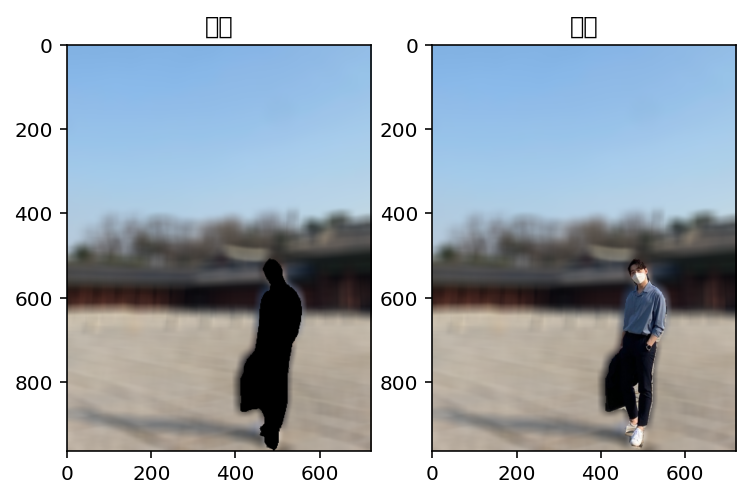

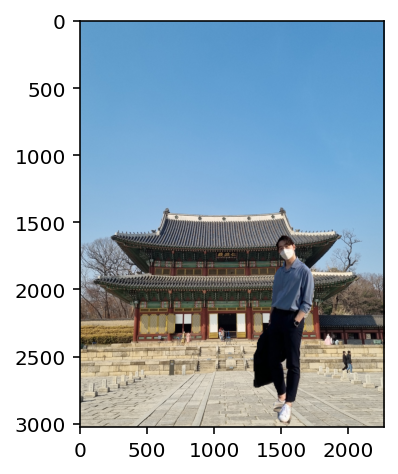

In [9]:
focusing('goung.jpg', 'person', 'BackGround.jpg')

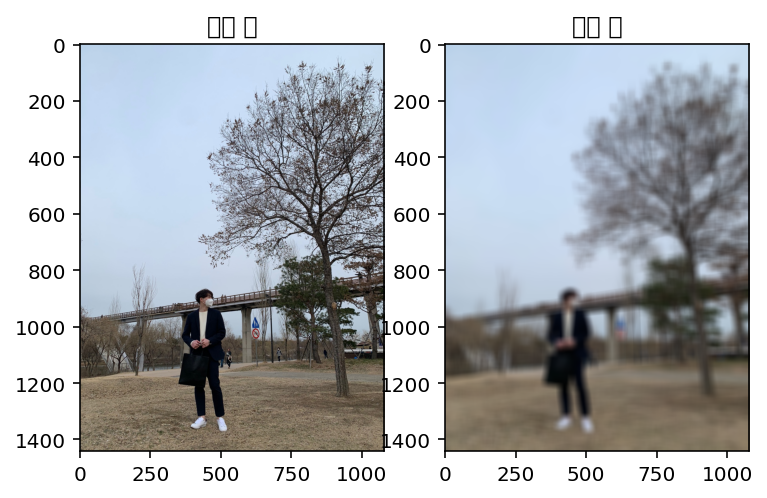

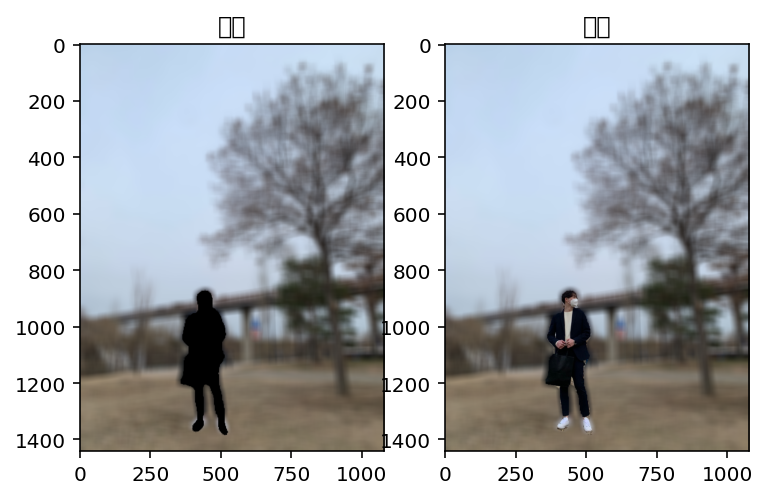

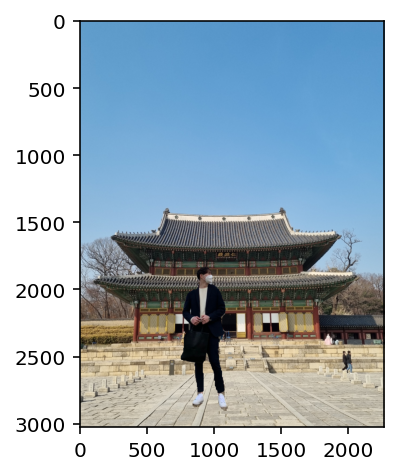

In [10]:
focusing('hangang.jpg', 'person', 'BackGround.jpg')

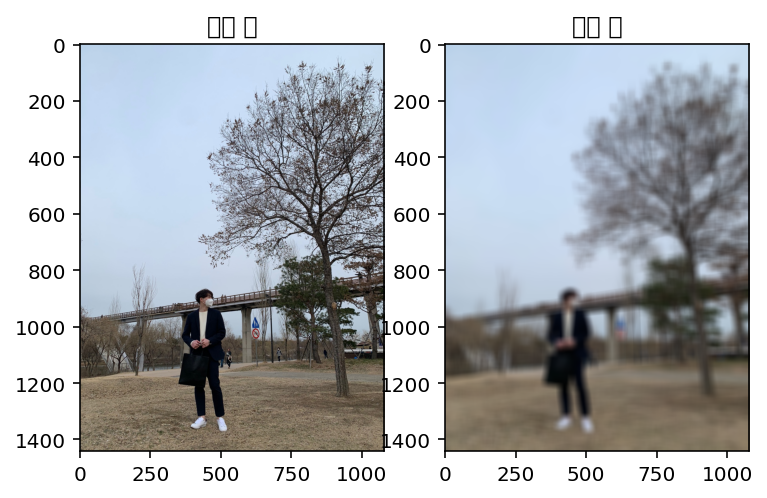

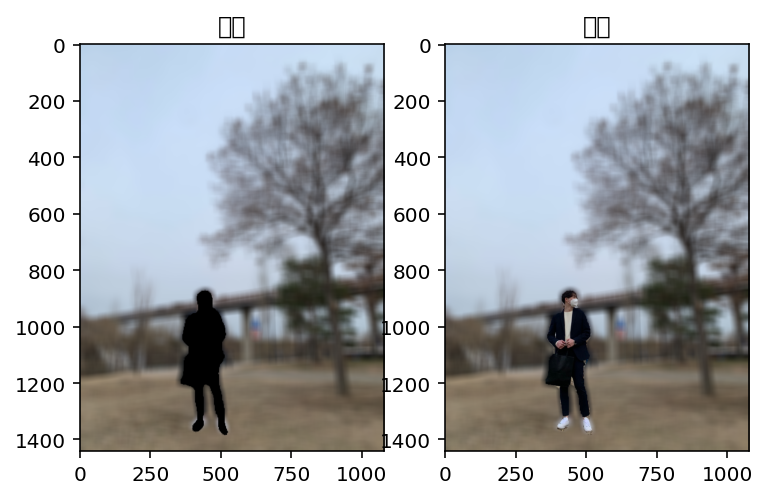

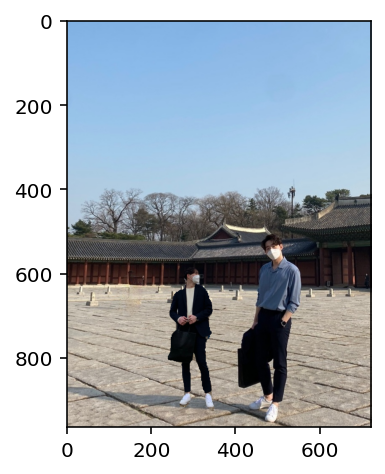

In [11]:
focusing('hangang.jpg', 'person', 'goung.jpg')

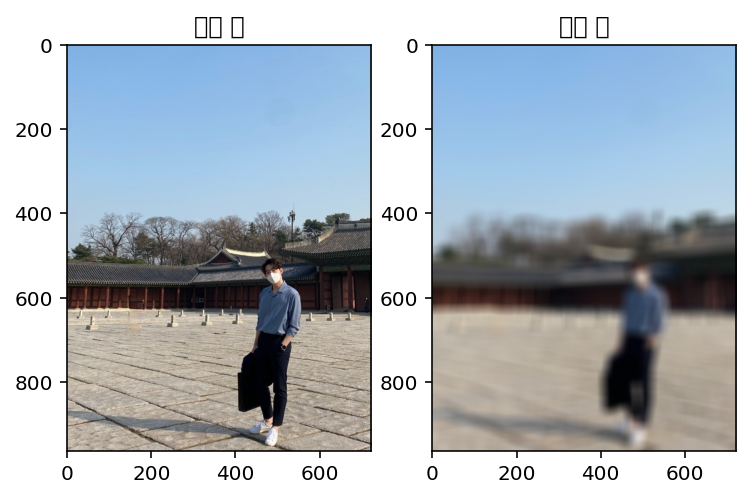

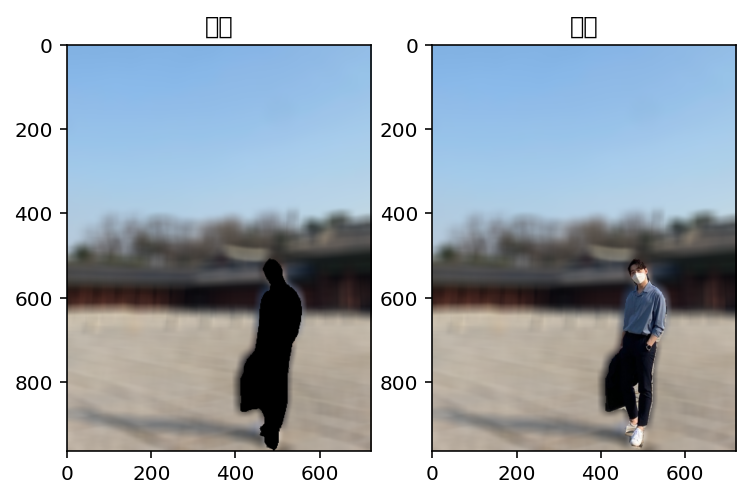

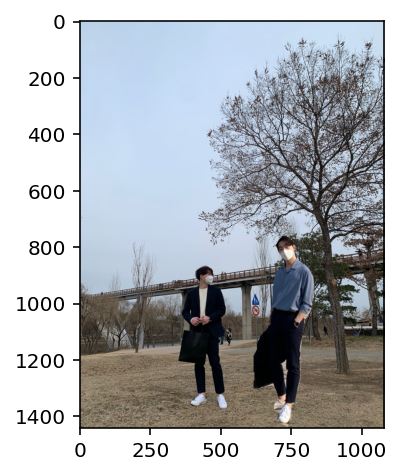

In [12]:
focusing('goung.jpg', 'person', 'hangang.jpg')

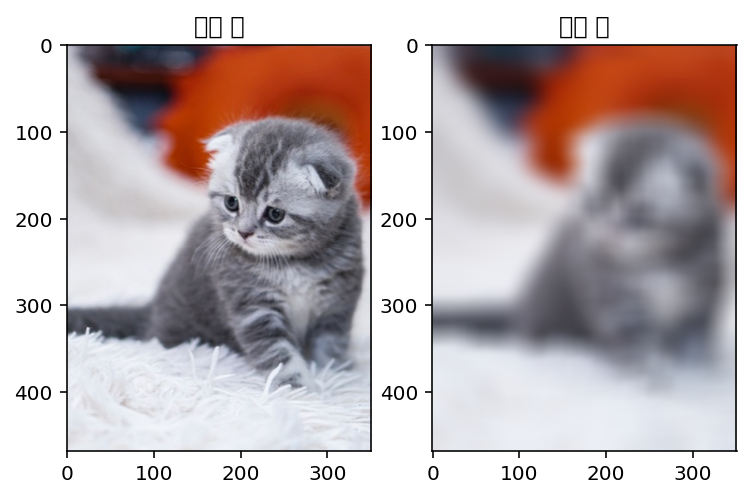

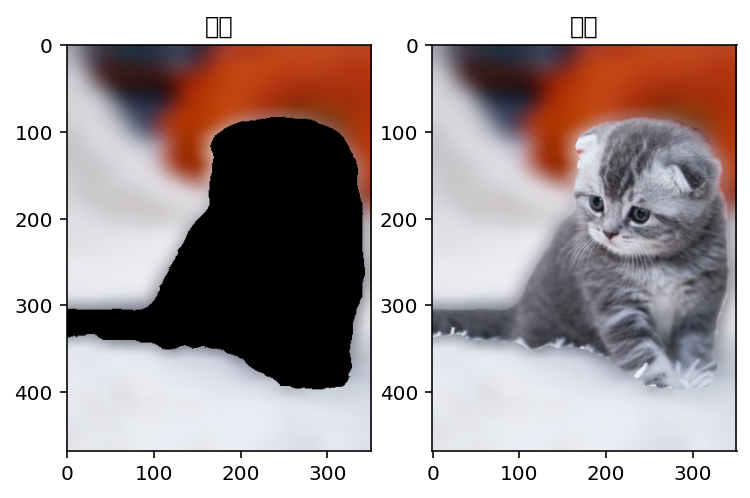

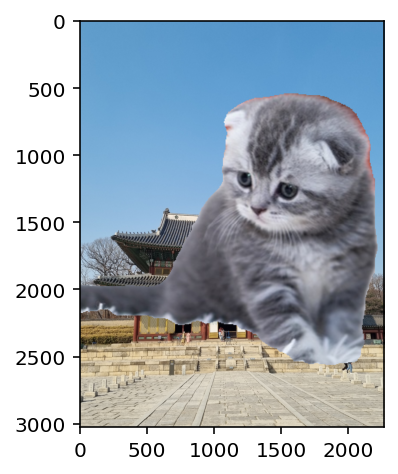

In [13]:
focusing('cat.jpg', 'cat', 'BackGround.jpg')

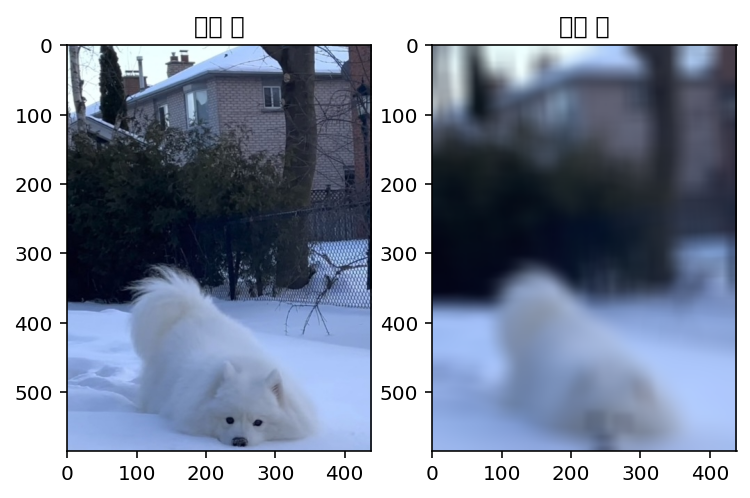

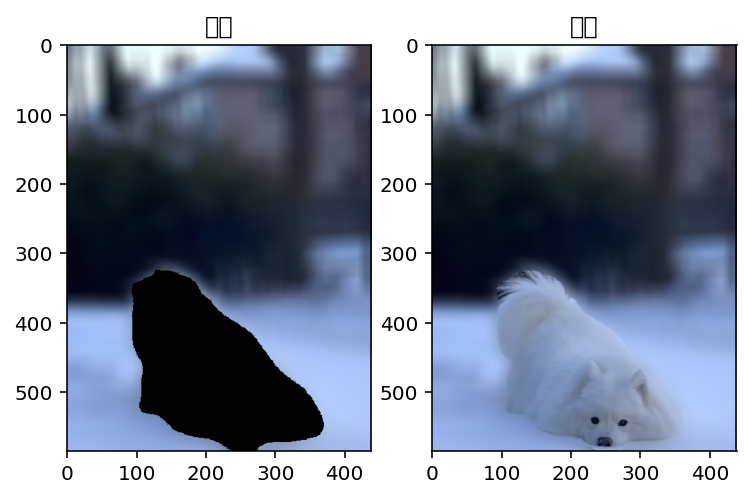

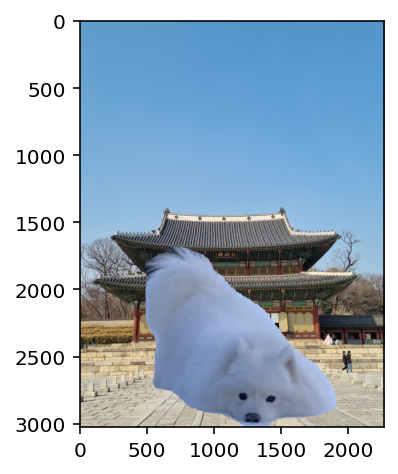

In [14]:
focusing('DOG.jpg', 'dog', 'BackGround.jpg')

### 5. 회고

1.

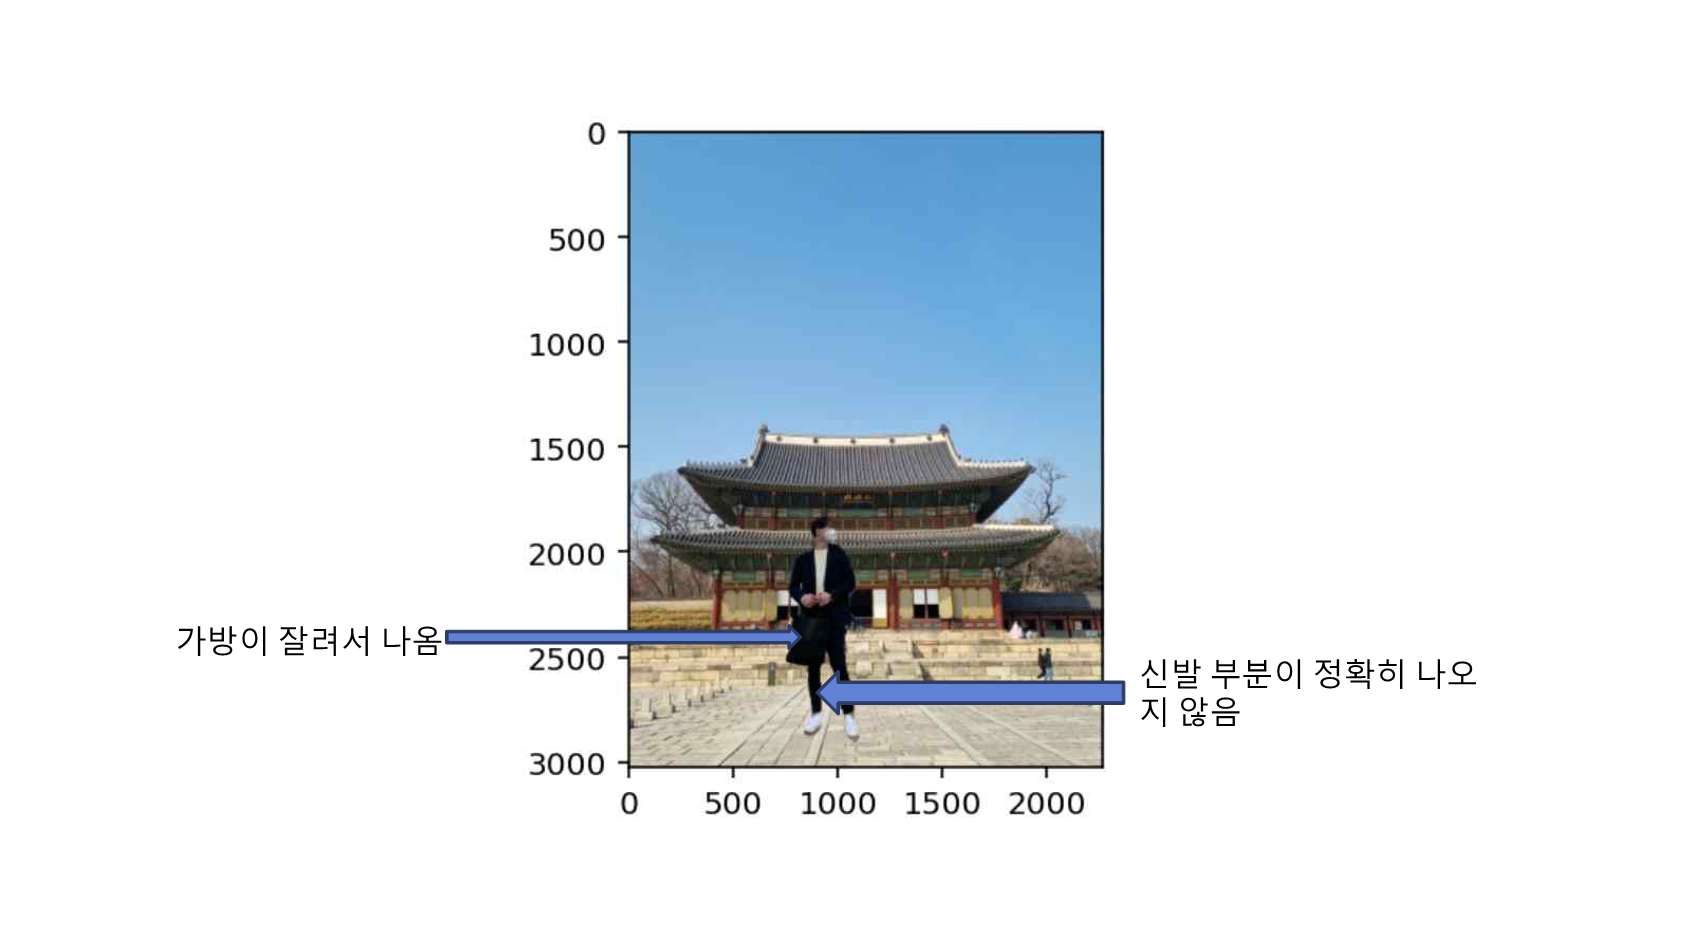

2.

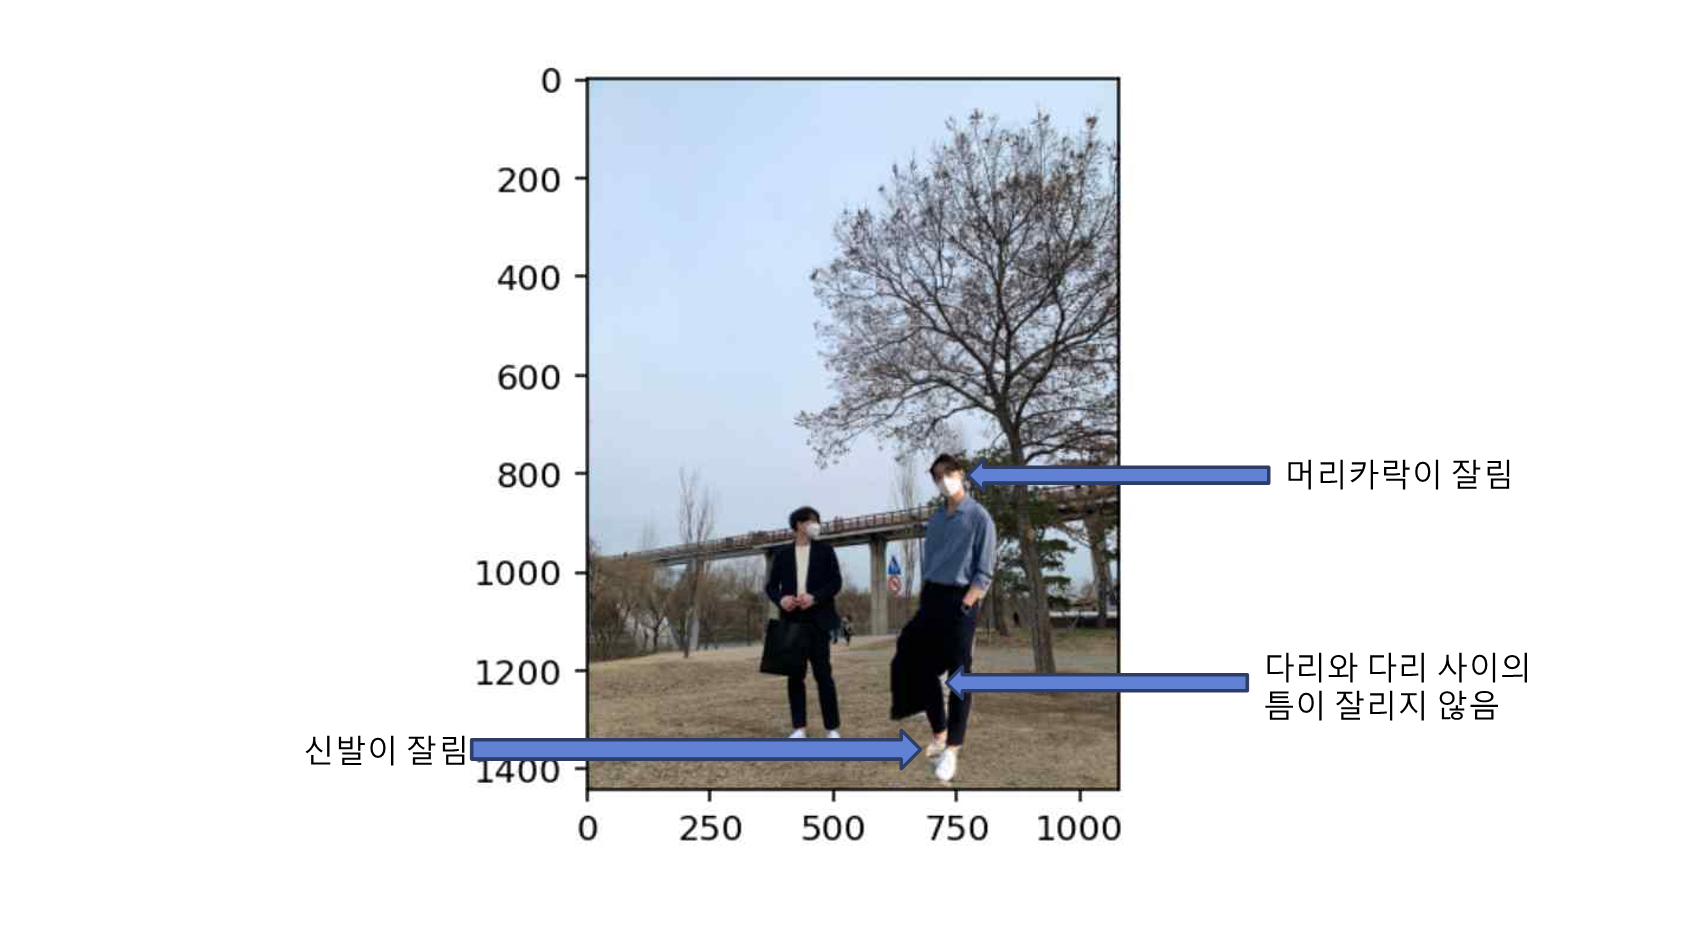

3.

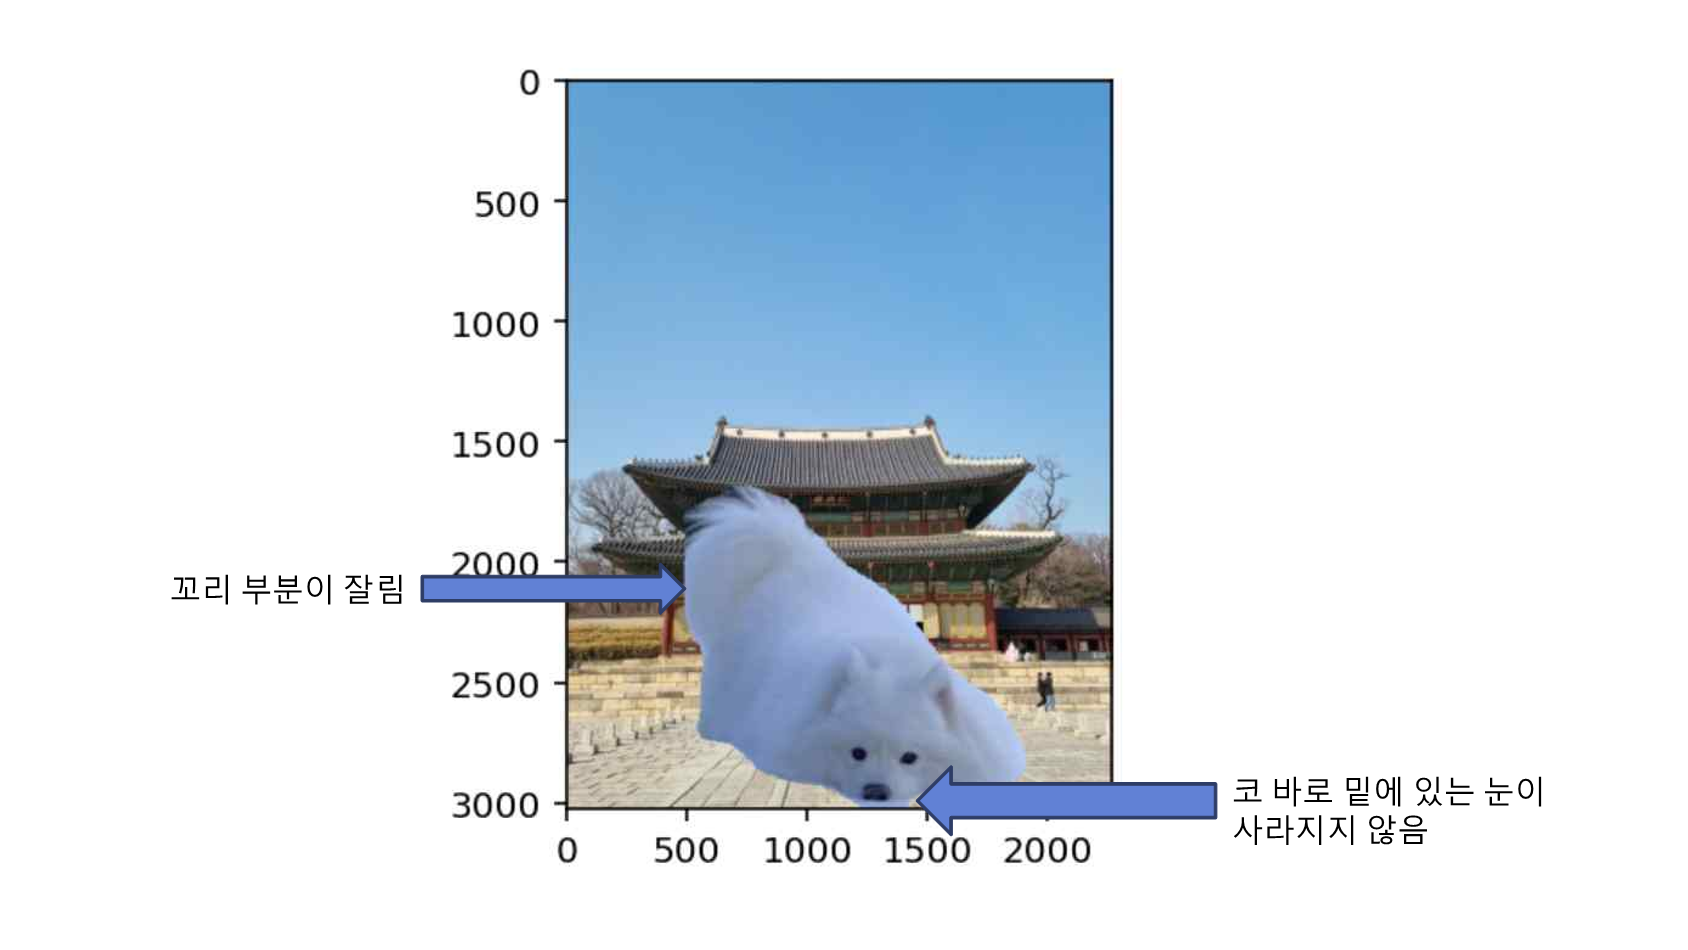

1. 얼핏 보았을 경우 사진을 잘 자른 것 처럼 보이지만 가까이 확대해서 확인하면 경계선이 불분명 한 것들이 보였음  
  
    
    

2. 3번 사진을 보면 휜 눈색에 파 묻힌 휜 강아지인데 대체적으로 잘 인식함 하지만 복실복실해 보이는 꼬리가 잘린 점은 정말 아쉬운 부분  
  
    
      
3. 다리와 다리 사이에 있는 틈은 대체적으로 구분하기 어려워 함 
  
    
    
4. 색이 비슷한 경우에도 대체적으로 잘 자르지 못함

__솔루션__ 
  
1. 하나의 그림을 9등분 혹은 더 작게 64등분 해서 잘못된 부분이 나온 구역을 조금더 명확히 지정 한 뒤 그 부분을 계속 학습 시키는 것도 좋을 것 같다고 생각함    
  
    
2. 피사체가 있는 사진과 피사체가 없는 사진을 각각 촬영하여 학습을 시키면 어느 정도 사람을 제대로 인식하여 정확도가 더 오를 수 있을 것이라고 생각함